In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TCNModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=29,
        output_chunk_length=1,
        num_filters=50,
        kernel_size=8,
        num_layers=3,
        dilation_base=4,
        weight_norm=True,
        n_epochs=100,
        batch_size=107,
        dropout=0.10987578257441336,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.004525867812805064, "weight_decay": 0.00015619537785532893}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.032
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.015
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.015. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE        R2  \
Temperature                   21.513746    4.638291    3.843666  0.570319   
Precipitation_accumulated      0.170101    0.412433    0.374453  0.730146   
Humidity                      82.972926    9.108948    7.197713  0.735778   
Wind_Speed_kmh                 0.330464    0.574860    0.424826  0.218116   
Soil_Moisture              54232.989849  232.879776  189.086554  0.912599   
Soil_Temperature               9.795036    3.129702    2.507786  0.865389   
Wind_Dir_Sin                   0.407327    0.638221    0.494492 -0.274578   
Wind_Dir_Cos                   0.519069    0.720465    0.543236 -0.341865   

                                SMAPE  
Temperature                 22.153017  
Precipitation_accumulated   11.799241  
Humidity                    10.981079  
Wind_Speed_kmh              48.159660  
Soil_Moisture   

Metric val_loss improved. New best score: 7.649
Metric val_loss improved by 0.203 >= min_delta = 0.001. New best score: 7.446
Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 7.391
Metric val_loss improved by 0.152 >= min_delta = 0.001. New best score: 7.239
Metric val_loss improved by 0.232 >= min_delta = 0.001. New best score: 7.007
Metric val_loss improved by 0.173 >= min_delta = 0.001. New best score: 6.834
Metric val_loss improved by 0.081 >= min_delta = 0.001. New best score: 6.753
Metric val_loss improved by 0.085 >= min_delta = 0.001. New best score: 6.668
Metric val_loss improved by 0.190 >= min_delta = 0.001. New best score: 6.478
Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 6.460
Metric val_loss improved by 0.050 >= min_delta = 0.001. New best score: 6.410
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 6.401
Metric val_loss improved by 0.099 >= min_delta = 0.001. New best score: 6.302
Monitored metric

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE           MAE  \
Temperature                4.492337e+04    211.951350    181.279543   
Precipitation_accumulated  1.769617e+04    133.026936    113.916682   
Humidity                   2.812014e+04    167.690620    143.094817   
Wind_Speed_kmh             2.160462e+02     14.698509     12.543166   
Soil_Moisture              3.859834e+08  19646.461284  16758.562940   
Soil_Temperature           4.355218e+04    208.691595    178.750831   
Wind_Dir_Sin               1.127725e+03     33.581613     28.738834   
Wind_Dir_Cos               3.260828e+03     57.103660     48.695668   

                                    R2       SMAPE  
Temperature               -1293.998212  150.232474  
Precipitation_accumulated     0.553162   34.562762  
Humidity                   -223.148159   79.574109  
Wind_Speed_kmh             -658.332329  157.711962  
Soil_

Metric val_loss improved. New best score: 0.021
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.008
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.007
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE            R2  \
Temperature                   2.772453   1.665068   1.295080  5.015749e-01   
Precipitation_accumulated   146.406455  12.099854   9.676344 -1.243662e+06   
Humidity                      9.657982   3.107729   2.448933  4.392034e-01   
Wind_Speed_kmh                0.077334   0.278090   0.228943          -inf   
Soil_Moisture              8460.470830  91.980818  72.067810 -5.322512e+00   
Soil_Temperature             11.042554   3.323034   2.903798 -7.489381e-01   
Wind_Dir_Sin                  0.013124   0.114560   0.104015          -inf   
Wind_Dir_Cos                  0.050598   0.224939   0.187045          -inf   

                                SMAPE  
Temperature                  8.965450  
Precipitation_accumulated    2.077919  
Humidity                     2.777202  
Wind_Speed_kmh             200.000000  
Soil_Mo

Metric val_loss improved. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/py

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   2.996910   1.731158   0.755323    -4.315925   
Precipitation_accumulated   118.984679  10.908010   8.390672 -3599.822927   
Humidity                      6.138547   2.477609   1.717863     0.370896   
Wind_Speed_kmh                0.040242   0.200605   0.149435         -inf   
Soil_Moisture              4017.799518  63.386115  49.024502     0.883678   
Soil_Temperature              4.635430   2.153005   1.032759   -19.490425   
Wind_Dir_Sin                  0.003953   0.062872   0.052781         -inf   
Wind_Dir_Cos                  0.001908   0.043684   0.034707         -inf   

                                SMAPE  
Temperature                 11.400554  
Precipitation_accumulated    1.846605  
Humidity                     1.869532  
Wind_Speed_kmh             200.000000  
Soil_Moisture   

Metric val_loss improved. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   0.749916   0.865977   0.676638     0.684244   
Precipitation_accumulated   323.960795  17.998911  16.127960 -1138.199557   
Humidity                     17.002260   4.123380   3.455015     0.635404   
Wind_Speed_kmh                0.010664   0.103266   0.082171    -4.127999   
Soil_Moisture              8613.953091  92.811384  68.152200    -0.070569   
Soil_Temperature              0.332690   0.576793   0.452499     0.794698   
Wind_Dir_Sin                  0.022165   0.148880   0.056464     0.616787   
Wind_Dir_Cos                  0.027203   0.164934   0.063115     0.692309   

                                SMAPE  
Temperature                  9.695775  
Precipitation_accumulated    3.591601  
Humidity                     4.162832  
Wind_Speed_kmh             188.953554  
Soil_Moisture   

Metric val_loss improved. New best score: 0.022
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.012
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.011
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    1.082333    1.040352    0.758480    0.884707   
Precipitation_accumulated    346.791150   18.622329   16.444218 -298.549554   
Humidity                       5.649836    2.376938    1.661590    0.951011   
Wind_Speed_kmh                 0.470781    0.686135    0.478765    0.697396   
Soil_Moisture              39413.840055  198.529192  155.233191    0.969162   
Soil_Temperature               2.066329    1.437473    1.049889    0.589477   
Wind_Dir_Sin                   0.363405    0.602831    0.431987    0.239268   
Wind_Dir_Cos                   0.293181    0.541462    0.410334    0.399194   

                                SMAPE  
Temperature                 25.840706  
Precipitation_accumulated    3.642189  
Humidity                     1.851474  
Wind_Speed_kmh              85.097982 

Metric val_loss improved. New best score: 0.016
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   2.118487   1.455502   1.057450    0.921703   
Precipitation_accumulated    60.967917   7.808195   6.095824 -207.611846   
Humidity                     13.354074   3.654323   2.730930    0.911610   
Wind_Speed_kmh                0.513142   0.716340   0.543738    0.572984   
Soil_Moisture              4651.068072  68.198740  54.228938    0.213555   
Soil_Temperature              0.953188   0.976314   0.818137    0.914515   
Wind_Dir_Sin                  0.384964   0.620454   0.496617    0.281962   
Wind_Dir_Cos                  0.330675   0.575043   0.473126    0.027099   

                                SMAPE  
Temperature                 10.998328  
Precipitation_accumulated    1.306580  
Humidity                     3.363513  
Wind_Speed_kmh              53.295196  
Soil_Moisture            

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TCNModel(output_chunk_shift=0, kernel_size=8, num_filters=50, num_layers=3, dilation_base=4, weight_norm=True, dropout=0.10987578257441336, model_name=model_1, input_chunk_length=29, output_chunk_length=1, n_epochs=100, batch_size=107, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fe8950ce990>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.004525867812805064, 'weight_decay': 0.00015619537785532893})

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


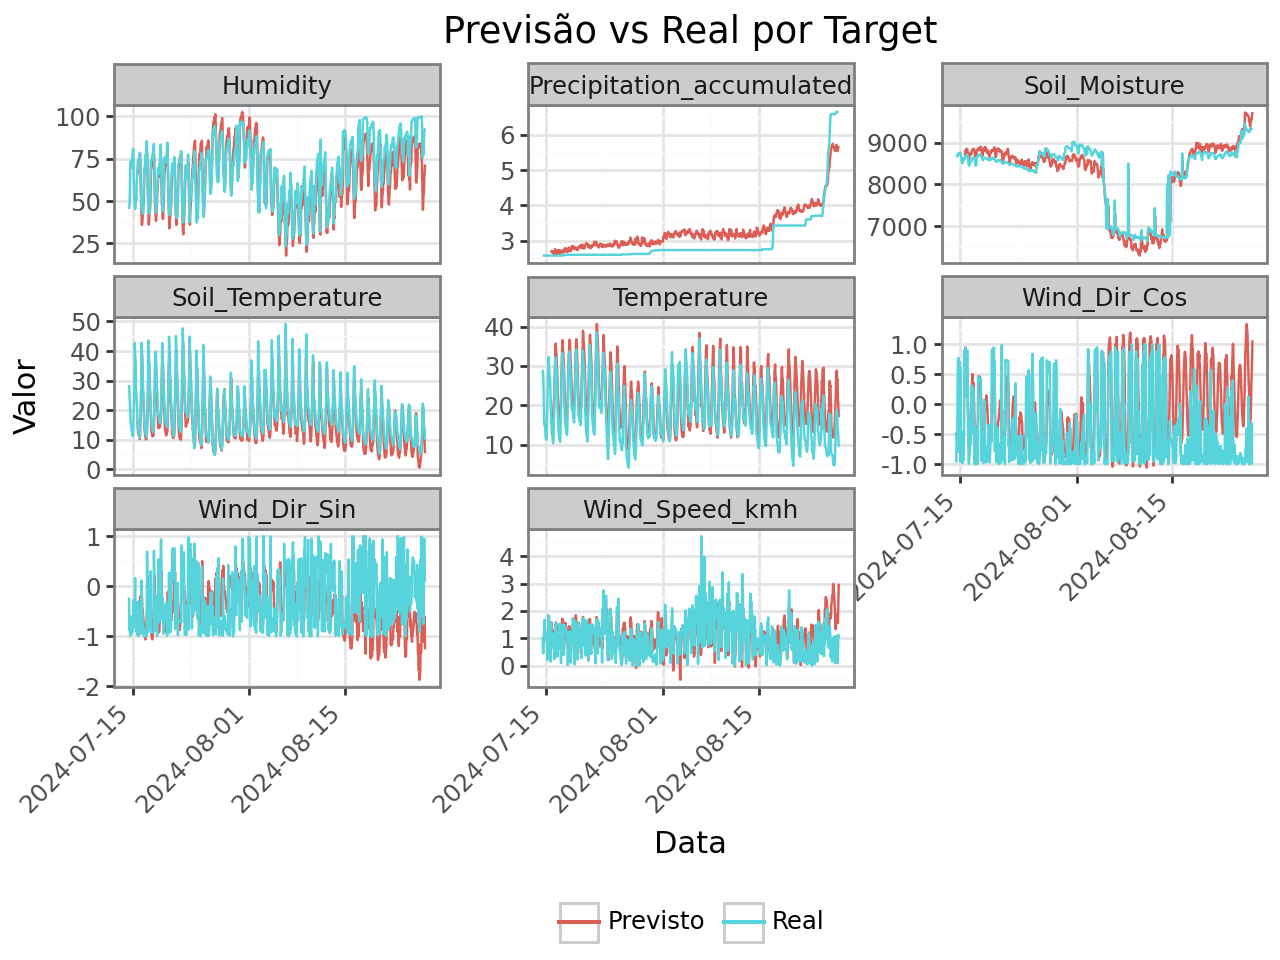

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

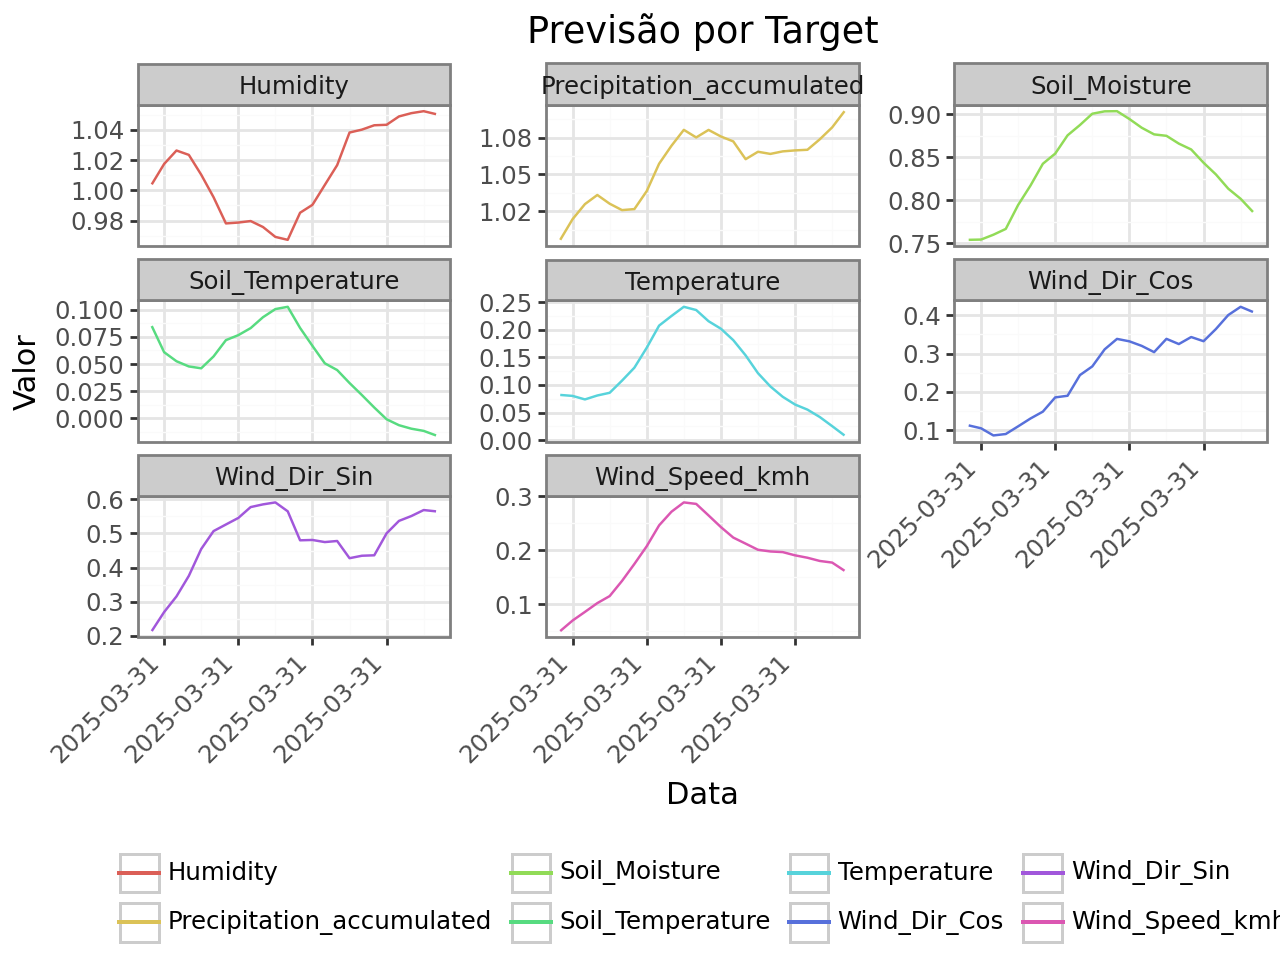

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [10]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)